# User identification based on keystroke dynamics
## PL in ML 2017
### Maciej Dziubiński @ Nethone

# Table of contents
1. [The dataset](#dataset)
2. [Feature extraction](#features)
3. [Training and test sets](#splitting)
4. [Custom cross-validation](#crossval)
5. [Model I: XGBoost](#xgboost)
6. [An interlude (AUC, feature scaling)](#interlude)
7. [Model II: the multilayer perceptron](#mlp)
8. [Model III: simple siamese model](#siamese)
9. [Model IV: RNN siamese model](#siamese_rnn)
10. [Tests on verification data](#testing)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-dark-palette')
mpl.style.use('seaborn-whitegrid')
%matplotlib inline

# The xgboost package throws a DeprecationWarning which we'll ignore
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Read in the data ("DataSet A" only) <a name="dataset"></a>

We will be using the [Bei Hang dataset](http://mpl.buaa.edu.cn/detail1.htm) which contains keystroke dynamics of the form:

[press1, release1, press2, release2, ...]

or:

**[P1, R1, P2, R2, ...]**

<img src="images/keystroke_only.png" alt="Drawing" style="width: 500;"/>

There are two datasets: "Dataset A", and "Dataset B", but we’ll only use the first one (collected in a cybercafe environment).

There are 49 users in "Dataset A", each with several keystroke timestamp sequences: [P1, R1, P2, R2, ...] produced while typing in a password during **registration** (depicted in violet below).
Each user has his own password, and in general different users have passwords of different lengths.

Additionally, a set of testing sequences was collected (**verification data** depicted in blue below), which we'll use for testing our model.

<img src="images/one_user.png" alt="Drawing" style="width: 500px;"/>

In [3]:
from read_data import produce_whole_DF


DF_whole = produce_whole_DF('BeiHang')

In [4]:
DF_whole.head()

,imposter,registration,sequence,user_name
0,1.0,0.0,"[0, 87217, 213229, 289532, 364336, 536949, 423...",12345
1,1.0,0.0,"[0, 89955, 213260, 292285, 385996, 563998, 478...",12345
2,0.0,0.0,"[0, 115585, 277341, 369844, 515214, 716555, 74...",12345
3,1.0,0.0,"[0, 94002, 140994, 240708, 282183, 411422, 415...",12345
4,1.0,0.0,"[0, 79023, 205029, 278599, 358789, 497964, 470...",12345


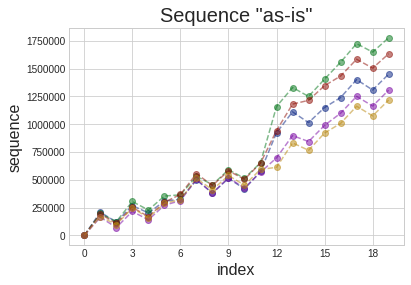

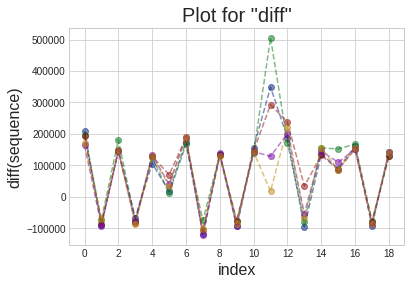

In [5]:
from plots import plot_user_sequences


user_name = 'zhuzhu'
plot_user_sequences(DF_whole, user_name)
plot_user_sequences(DF_whole, user_name, np.diff)

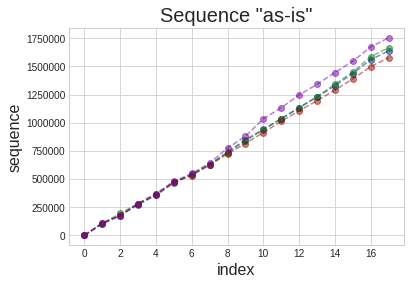

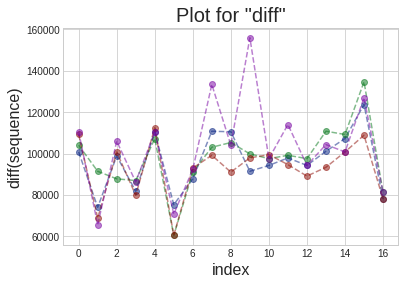

In [6]:
user_name = 'qianhai18'
plot_user_sequences(DF_whole, user_name)
plot_user_sequences(DF_whole, user_name, np.diff)

# (Crude) feature extraction <a name="features"></a>

The most commonly used (sub-)sequences extracted from the keystroke sequence are the **dwell** and **flight times**.

![](images/keystroke.png)

As features, we'll use the **mean** and **standard deviation** of the dwell and flight times.

We'll also use the mean and std of the first order difference (`diff[n] = seq[n+1] - seq[n]`), using the `np.diff` function.

In [7]:
def extract_flight_times(seq):
    """Flight time -- time between key up and the next key down"""
    return seq[2::2] - seq[1:-1:2]


def extract_dwell_times(seq):
    """Dwell time -- time spent in pressing a key"""
    return seq[1::2] - seq[::2]
    
    
def extract_features(seq):
    """Function calculating basic statistic from a sequence of
    keystroke timestamps (argument `seq`).
    """
    diff = np.diff(seq)
    dwell = extract_dwell_times(seq)
    flight = extract_flight_times(seq)
    # TODO(1): add more features

    return {
        'diff_mean': diff.mean(),
        'diff_std': diff.std(),
        'dwell_mean': dwell.mean(),
        'dwell_std': dwell.std(),
        'flight_mean': flight.mean(),
        'flight_std': flight.std(),
    }

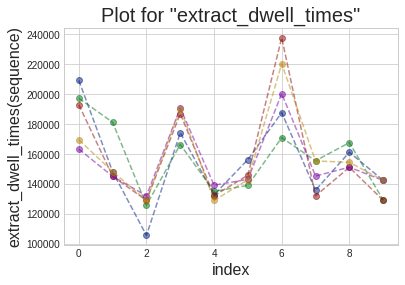

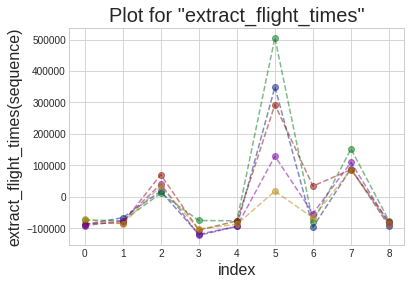

In [8]:
user_name = 'zhuzhu'
plot_user_sequences(DF_whole, user_name, extract_dwell_times)
plot_user_sequences(DF_whole, user_name, extract_flight_times)

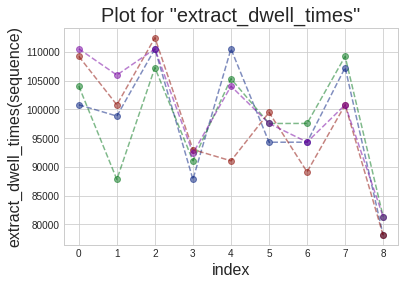

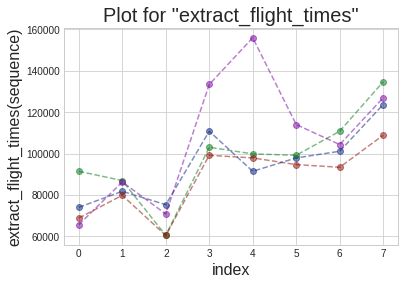

In [9]:
user_name = 'qianhai18'
plot_user_sequences(DF_whole, user_name, extract_dwell_times)
plot_user_sequences(DF_whole, user_name, extract_flight_times)

In [10]:
DF_features = (DF_whole['sequence']
               .apply(extract_features)
               .apply(pd.Series))

base_feature_names = DF_features.columns.tolist()
DF_whole = pd.concat([DF_whole, DF_features], axis=1)

In [11]:
DF_whole.head()

,imposter,registration,sequence,user_name,diff_mean,diff_std,dwell_mean,dwell_std,flight_mean,flight_std
0,1.0,0.0,"[0, 87217, 213229, 289532, 364336, 536949, 423...",12345,85998.434783,101921.007371,115816.666667,35073.544587,53469.454545,135462.394716
1,1.0,0.0,"[0, 89955, 213260, 292285, 385996, 563998, 478...",12345,97628.086957,118751.855814,118454.500000,34463.576520,74908.363636,164927.063718
2,0.0,0.0,"[0, 115585, 277341, 369844, 515214, 716555, 74...",12345,164243.521739,147029.169220,137851.750000,35829.262919,193034.545455,205453.593070
3,1.0,0.0,"[0, 94002, 140994, 240708, 282183, 411422, 415...",12345,77916.304348,64534.769289,99618.750000,17394.501455,54240.909091,85461.523826
4,1.0,0.0,"[0, 79023, 205029, 278599, 358789, 497964, 470...",12345,77267.217391,63820.887916,111666.916667,29918.069903,39740.272727,69576.172746


# Split into train and test <a name="splitting"></a>

In [12]:
test_user_names = sorted([
    'wukun88',
    'wwwh',
    'x335399102',
    'xiaoji',
    'xiaotian',
    'xiaowei',
    'xiaoxiong',
    'zhangyue1',
    'zhuzhu',
    'kk773510555',
    'kuijhu',
    'lokiu',
    'oikjuy',
    'qianhai18',
    'saiwaiba',
])


DF_registration_train = DF_whole.query(
    '(registration == 1) and (user_name not in @test_user_names)'
)

## Extracting pairs of keystroke dynamics

We'll train several binary classifiers which for a given pair of sequences will predict whether the pair was produced by the same user (1), or rather by two different users (0).

For that, we will use the registration sequences, and pair them up to create a feature matrix to train the model.

<img src="images/pairing.png" alt="Drawing" style="width: 800px;"/>

 The following function, `extract_pairs`, produces a pandas DataFrame that contains the feature matrix, $\mathbb{X}$, but also the labels, $\mathbf{y}$ (column `'label'`).

In [13]:
from pair_data import extract_pairs

### Important note
We will train two types of models.

The **first type of models** will receive as input a feature matrix, $\mathbb{X}$, whose rows will be absolute differences of the feature vectors of the paired sequences:

<img src="images/feature_difference.png" alt="Drawing" style="width: 800px;"/>

The **second type of models**, the siamese models, will receive a cross product of the features of the sequences, therefore the frame will have twice the width:

<img src="images/feature_concat.png" alt="Drawing" style="width: 1000px;"/>

(Note that the above image shows a concatenation of two frames, rather than a cross product, but it correctly shows how the resultant frame might look like.)

## As an example

In [14]:
DF_train_all_pairs = extract_pairs(DF_registration_train, base_feature_names, only_feature_diffs=True)
print(
    'Fraction of positive observations: {:.4f}'
    .format(DF_train_all_pairs['label'].mean())
)
DF_train_all_pairs.head()

Fraction of positive observations: 0.0247


,diff_mean,diff_std,dwell_mean,dwell_std,flight_mean,flight_std,label
0,194527.786561,140151.680666,23270.666667,2003.133965,388191.418182,204178.383065,0
1,114287.830040,12734.001716,16401.750000,4612.066942,227910.327273,50906.165765,0
2,118841.786561,105145.835542,3008.916667,3676.554173,252042.600000,184084.415449,0
3,179448.395257,377017.376112,13699.000000,13529.757182,396992.327273,559773.143389,0
4,211243.584541,156363.500715,44715.333333,3614.124301,402130.068182,238389.545630,0


# Custom cross validation score (AUC, actually) <a name="crossval"></a>

In [15]:
from copy import deepcopy
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score


def custom_cross_val_auc_score(estimator, DF_registration,
                               num_folds=4, seed=0):
    """Function for performing cross-validation of a model identifying
    whether two keystroke dynamics come from the same user.
    
    We need to split the DF_registration frame with respect to "user_name"s
    (to avoid data leakage), and then create the training and validation frames
    (DF_train and DF_valid), which contain information about pairs of
    keystroke dynamics (using the `extract_pairs` function).
    
    Args:
        estimator: an object supplying the estimator.fit, and estimator.predict_proba
            methods (preferably: an object of the class sklearn.pipeline.Pipeline
            class), but also two attributes: estimator.only_feature_diffs, and
            estimator.feature_names.
    
        DF_registration: a pd.DataFrame that should contain only registration
            data.
            
        num_folds: the number of folds for the cross validation split (the "k"
            in "k-fold cross-validation").
            
        seed: a random numbe generator seed (passed to np.random.seed) to ensure
            reproducibility of the results.
        
    Returns:
        (auc_scores, best_classifier): a list of AUC scores, and the classifier
            that produced the best AUC.
    """
    user_names = DF_registration['user_name'].unique()
    only_feature_diffs = estimator.only_feature_diffs
    feature_names = estimator.feature_names
    cv = KFold(num_folds)
    np.random.seed(seed)
    cv_iter = list(cv.split(user_names))
    auc_scores = []
    best_auc_score = -100000
    best_classifier = None
    best_y_true = None
    best_y_pred = None
    for train_user_names_selector, valid_user_names_selector in cv_iter:
        if len(valid_user_names_selector) == 1:
            print('Ignoring a fold with a single validation user'
                  ' (consider lowering the value of `num_folds`)')
            continue
        estimator_copy = deepcopy(estimator)
        train_user_names = user_names[train_user_names_selector]
        DF_registration_train = DF_registration.query('user_name in @train_user_names')
        DF_registration_valid = DF_registration.query('user_name not in @train_user_names')
        DF_train = extract_pairs(DF_registration_train, feature_names, only_feature_diffs)
        DF_valid = extract_pairs(DF_registration_valid, feature_names, only_feature_diffs)
        y = DF_train['label']
        X_train = DF_train.drop('label', 1)
        
        estimator_copy.fit(X_train, y)
        
        X_valid = DF_valid.drop('label', 1)
        y_pred = estimator_copy.predict_proba(X_valid)
        if y_pred.shape[1] == 2:
            y_pred = y_pred[:, 1]
        y_true = DF_valid['label']
        auc_score = roc_auc_score(y_true, y_pred)
        if auc_score > best_auc_score:
            best_auc_score = auc_score
            best_estimator = estimator_copy
            best_y_true = y_true
            best_y_pred = y_pred
        auc_scores.append(auc_score)

    return auc_scores, best_estimator, best_y_true, best_y_pred

# XGBoost -- our baseline estimator <a name="xgboost"></a>

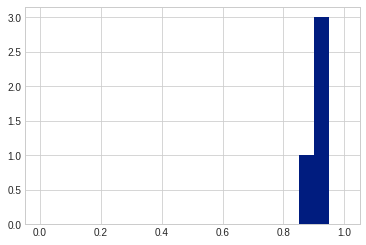

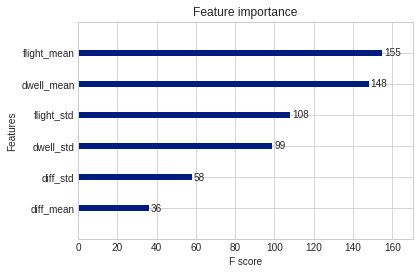

In [16]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance
from sklearn.pipeline import Pipeline


xgb_pipe = Pipeline([
    ('XGBClassifier', XGBClassifier()),
])

# We're setting the following attributes manually;
# they will be needed in the `custom_cross_val_auc_score`, and 
# `test_user_verification` functions, that's why I prefer
# to have them as attributes of a Pipeline
xgb_pipe.only_feature_diffs = True
xgb_pipe.feature_names = base_feature_names


scores, best_xgb_pipe, y_true, y_pred = custom_cross_val_auc_score(
    xgb_pipe,
    DF_registration_train,
)

plt.hist(scores, range=(0, 1), bins=20);
xgb_classifier = best_xgb_pipe.steps[-1][1]
plot_importance(xgb_classifier);

# An interlude <a name="interlude"></a>

## ROC and the AUC score

A Receiver Operating Characteristic (ROC) curve illustrates the performance of a binary classifier as its discrimination threshold (cutoff) is changed.

The value of the Area Under the Curve (AUC) of the ROC is a score used to measure the quality of a classifier.

The AUC measures how well model’s predictions rank the observations.

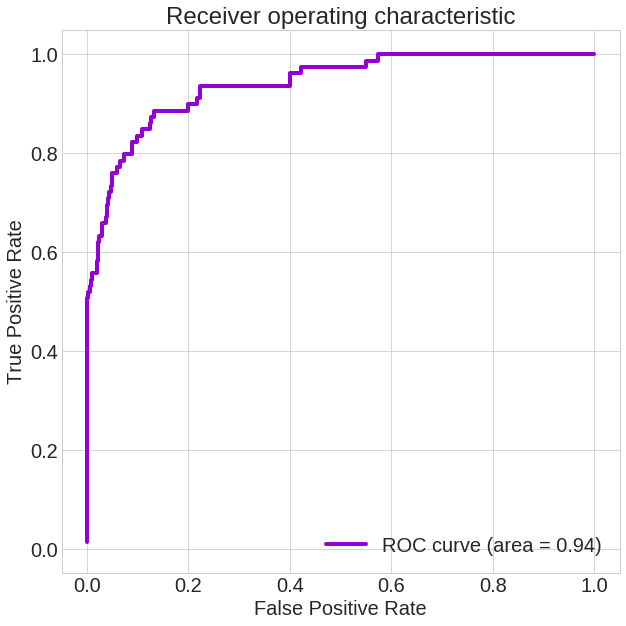

In [17]:
from plots import plot_auc

    
plot_auc(y_true, y_pred)

## Before talking about neural networks, let's see if our data need to be standardized...

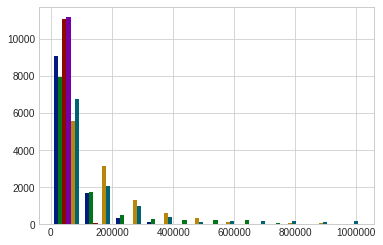

In [18]:
plt.hist(DF_train_all_pairs.drop('label', axis=1).values);

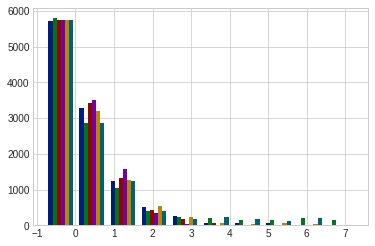

In [19]:
from sklearn.preprocessing import RobustScaler
# TODO(1): is there a better normalization method?


norm_pipe = Pipeline([
    ('RobustScaler', RobustScaler())
])

X_train_norm = norm_pipe.fit_transform(DF_train_all_pairs.drop('label', axis=1))

plt.hist(X_train_norm);

## But because we'll want to work with `pd.DataFrame` (we need column names)

In [20]:
class RobustScalerForPandas(RobustScaler):
    """A wrapper class, that performs fit/transform,
    but keeps the data as a pd.DataFrame.
    
    Estimators defined further on -- MLPKerasWrapper, SimplestSiameseModel,
    and RNNSiameseModel -- work only with pd.DataFrames, but the
    sklearn's RobustScaler returns a numpy matrix.
    Therefore, this wrapper is used in sklearn's Pipelines whenever we
    use the aforementioned estimators.
    """
    def fit(self, DF_data, y=None):
        super().fit(DF_data.values)
        return self
    
    def transform(self, DF_data, y=None):
        colnames = DF_data.columns
        return pd.DataFrame(
            super().transform(DF_data.values),
            columns=colnames,
        )

# The multilayer perceptron (MLP) model <a name="mlp"></a>

![](images/mlp.png)

Source: https://cs231n.github.io/neural-networks-1

In [21]:
# TODO(3): ensure reproducibility with the tensorflow backend;
# see Issue: https://github.com/keras-team/keras/issues/2280
# (without sacrificing speed)
import keras.backend as K
from keras.layers import Input, Dense, Dropout, ELU
from keras.models import Model
from keras.utils.np_utils import to_categorical
from keras.regularizers import l2


class MLPKerasWrapper:
    """This is a wrapper class, allowing us to use a keras model in
    sklearn's Pipeline.
    
    We want to be able to use instances of this class to perform cross-validation
    in the custom_cross_val_auc_score function, and then to perform tests
    with the test_user_verification function.
    
    Keras has its own wrappers (see the keras.wrappers.scikit_learn submodule),
    but they were not sufficient for our purposes.
    """
    
    def __init__(self, inp_shape,
                 num_epochs=10, num_neurons=40, num_layers=2, reg=1e-3):
        self.inp_shape = inp_shape
        self.num_neurons = num_neurons
        self.num_layers = num_layers
        self.reg = reg
        self.num_epochs = num_epochs

    def fit(self, DF_data, y):        
        # Every time we're calling `fit`, we need a whole new set of initial
        # weights in the model; I haven't found a clean way of doing this
        # automatically in keras, so to avoid potential errors, we're
        # re-initializing the model to make sure it's going to be fit
        # from scratch
        self._init_model()  # TODO(2): can we do better?
        
        # TODO(1): tweak the class_weight values
        self.model.fit(
            x=DF_data.values,
            y=y,
            verbose=2,
            epochs=self.num_epochs,
            class_weight=None,
        )
        return self

    def predict_proba(self, DF_data):
        return self.model.predict(DF_data.values)
    
    def _init_model(self):
        inp = Input(shape=self.inp_shape)

        x = Dense(self.num_neurons, kernel_regularizer=l2(self.reg))(inp)
        x = ELU()(x)
        for _ in range(self.num_layers-1):
            x = Dense(self.num_neurons, kernel_regularizer=l2(self.reg))(x)
            x = ELU()(x)

        x = Dense(1, activation='sigmoid')(x)

        self.model = Model(inputs=inp, outputs=x)
        # TODO(1): try out different optimization algorithms
        # and/or different learning rates
        self.model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
        )

/home/md/anaconda3/envs/workshop/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/md/anaconda3/envs/workshop/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Epoch 1/10
0s - loss: 0.2741
Epoch 2/10
0s - loss: 0.1417
Epoch 3/10
0s - loss: 0.1277
Epoch 4/10
0s - loss: 0.1219
Epoch 5/10
0s - loss: 0.1153
Epoch 6/10
0s - loss: 0.1118
Epoch 7/10
0s - loss: 0.1093
Epoch 8/10
0s - loss: 0.1074
Epoch 9/10
0s - loss: 0.1058
Epoch 10/10
0s - loss: 0.1042
Epoch 1/10
0s - loss: 0.2874
Epoch 2/10
0s - loss: 0.1368
Epoch 3/10
0s - loss: 0.1226
Epoch 4/10
0s - loss: 0.1145
Epoch 5/10
0s - loss: 0.1073
Epoch 6/10
0s - loss: 0.1036
Epoch 7/10
0s - loss: 0.1021
Epoch 8/10
0s - loss: 0.0987
Epoch 9/10
0s - loss: 0.0970
Epoch 10/10
0s - loss: 0.0959
Epoch 1/10
0s - loss: 0.2983
Epoch 2/10
0s - loss: 0.1436
Epoch 3/10
0s - loss: 0.1308
Epoch 4/10
0s - loss: 0.1231
Epoch 5/10
0s - loss: 0.1175
Epoch 6/10
0s - loss: 0.1125
Epoch 7/10
0s - loss: 0.1096
Epoch 8/10
0s - loss: 0.1064
Epoch 9/10
0s - loss: 0.1049
Epoch 10/10
0s - loss: 0.1030
Epoch 1/10
0s - loss: 0.2589
Epoch 2/10
0s - loss: 0.1397
Epoch 3/10
0s - loss: 0.1263
Epoch 4/10
0s - loss: 0.1182
Epoch 5/10


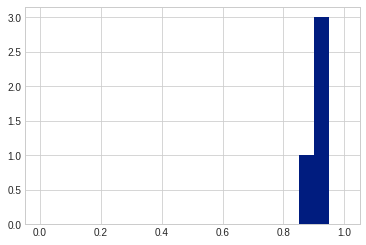

In [22]:
mlp_pipe = Pipeline([
    ('RobustScalerForPandas', RobustScalerForPandas()),
    ('MLPKerasWrapper', MLPKerasWrapper(inp_shape=(len(base_feature_names), ))),
])

mlp_pipe.only_feature_diffs = True
mlp_pipe.feature_names = base_feature_names


scores, best_mlp_pipe, y_true, y_pred = custom_cross_val_auc_score(
    mlp_pipe,
    DF_registration_train,
)

plt.hist(scores, range=(0, 1), bins=20);

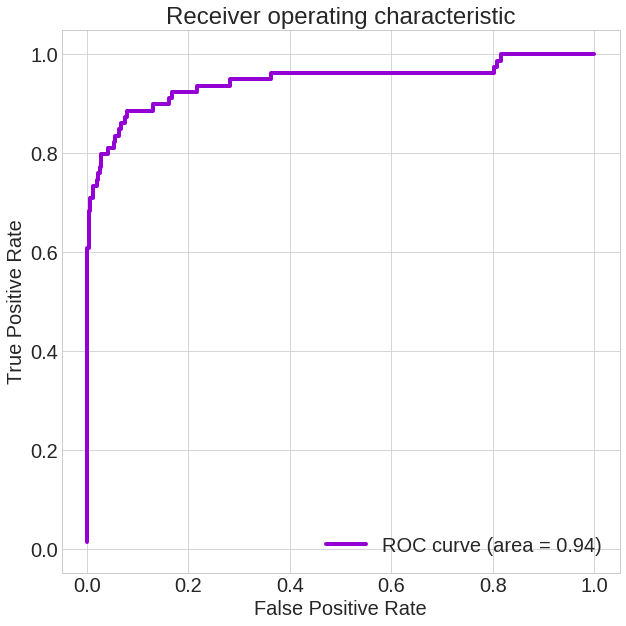

In [23]:
plot_auc(y_true, y_pred)

# Siamese models <a name="siamese"></a>

In [24]:
DF_train_all_pairs = extract_pairs(DF_registration_train, base_feature_names, only_feature_diffs=False)
print(
    'Fraction of positive observations: {:.4f}'
    .format(DF_train_all_pairs['label'].mean())
)
DF_train_all_pairs.head()

Fraction of positive observations: 0.0247


,diff_mean_A,diff_std_A,dwell_mean_A,dwell_std_A,flight_mean_A,flight_std_A,diff_mean_B,diff_std_B,dwell_mean_B,dwell_std_B,flight_mean_B,flight_std_B,label
0,270614.695652,233027.603479,162036.333333,20617.251087,389063.818182,293573.399375,76086.909091,92875.922812,138765.666667,22620.385052,872.40,89395.016310,0
1,270614.695652,233027.603479,162036.333333,20617.251087,389063.818182,293573.399375,59371.111111,76664.102764,117321.000000,24231.375388,-13066.25,55183.853745,0
2,270614.695652,233027.603479,162036.333333,20617.251087,389063.818182,293573.399375,62137.333333,92752.325817,130604.000000,25534.659810,-23446.00,73195.630406,0
3,270614.695652,233027.603479,162036.333333,20617.251087,389063.818182,293573.399375,72264.777778,94515.417209,141243.200000,23950.965671,-13958.25,77463.664532,0
4,270614.695652,233027.603479,162036.333333,20617.251087,389063.818182,293573.399375,74714.666667,96691.594925,142961.400000,18930.099890,-10593.75,86535.325854,0


## Siamese neural network (MLP)

<img src="images/siamese_mlp.png" alt="Drawing" style="width: 800px;"/>

In [25]:
import keras.backend as K
from keras.layers import Lambda


class SimplestSiameseModel:
    """(Same intro as for MLPKerasWrapper.)
    
    This class implements a siamese architecture, in which the base model
    is a simple MLP.
    """
    def __init__(self, inp_shape,
                 num_epochs=10, num_neurons=40, num_layers=2, reg=1e-3):
        self.inp_shape = inp_shape
        self.num_neurons = num_neurons
        self.num_layers = num_layers
        self.reg = reg
        self.num_epochs = num_epochs

    def fit(self, DF_data, y):
        columns_A, columns_B = self._extract_columns(DF_data)
        
        self._init_model()
        
        self.siamese_net.fit(
            x=[DF_data[columns_A].values, DF_data[columns_B].values],
            y=y,
            batch_size=32,
            epochs=self.num_epochs,
            verbose=2,
        )

    def predict_proba(self, DF_data):
        columns_A, columns_B = self._extract_columns(DF_data)
        return self.siamese_net.predict(
            [DF_data[columns_A].values, DF_data[columns_B].values]
        )
    
    def _init_model(self):
        input_A = Input(self.inp_shape)
        input_B = Input(self.inp_shape)

        base_network = self._create_base_network()

        leg_A = base_network(input_A)
        leg_B = base_network(input_B)

        # Merge two representations using an absolute difference between them
        def abs_diff(x): return K.abs(x[0] - x[1])
        diff = Lambda(function=abs_diff,
                      output_shape=lambda x: x[0])([leg_A, leg_B])
        x = Dense(self.num_neurons)(diff)
        x = ELU()(x)
        prediction = Dense(1, activation='sigmoid')(x)

        self.siamese_net = Model([input_A, input_B], prediction)
        self.siamese_net.compile(
            optimizer='adam',
            loss='binary_crossentropy',
        )

    def _create_base_network(self):
        inp = Input(shape=self.inp_shape)
        x = Dense(self.num_neurons, kernel_regularizer=l2(self.reg))(inp)
        x = ELU()(x)
        for _ in range(self.num_layers-1):
            x = Dense(self.num_neurons, kernel_regularizer=l2(self.reg))(x)
            x = ELU()(x)
        return Model(inputs=inp, outputs=x)
    
    def _extract_columns(self, DF_data):
        columns = DF_data.columns
        columns_A = columns[columns.str.contains('_A')]
        columns_B = columns[columns.str.contains('_B')]
        return columns_A, columns_B

Epoch 1/10
0s - loss: 0.2435
Epoch 2/10
0s - loss: 0.1608
Epoch 3/10
0s - loss: 0.1367
Epoch 4/10
0s - loss: 0.1210
Epoch 5/10
0s - loss: 0.1118
Epoch 6/10
0s - loss: 0.1045
Epoch 7/10
0s - loss: 0.0997
Epoch 8/10
0s - loss: 0.0962
Epoch 9/10
0s - loss: 0.0927
Epoch 10/10
0s - loss: 0.0905
Epoch 1/10
0s - loss: 0.2145
Epoch 2/10
0s - loss: 0.1515
Epoch 3/10
0s - loss: 0.1287
Epoch 4/10
0s - loss: 0.1155
Epoch 5/10
0s - loss: 0.1067
Epoch 6/10
0s - loss: 0.0999
Epoch 7/10
0s - loss: 0.0960
Epoch 8/10
0s - loss: 0.0927
Epoch 9/10
0s - loss: 0.0895
Epoch 10/10
0s - loss: 0.0863
Epoch 1/10
0s - loss: 0.2367
Epoch 2/10
0s - loss: 0.1563
Epoch 3/10
0s - loss: 0.1337
Epoch 4/10
0s - loss: 0.1208
Epoch 5/10
0s - loss: 0.1137
Epoch 6/10
0s - loss: 0.1089
Epoch 7/10
0s - loss: 0.1061
Epoch 8/10
0s - loss: 0.1016
Epoch 9/10
0s - loss: 0.0990
Epoch 10/10
0s - loss: 0.0977
Epoch 1/10
0s - loss: 0.2237
Epoch 2/10
0s - loss: 0.1596
Epoch 3/10
0s - loss: 0.1371
Epoch 4/10
0s - loss: 0.1256
Epoch 5/10


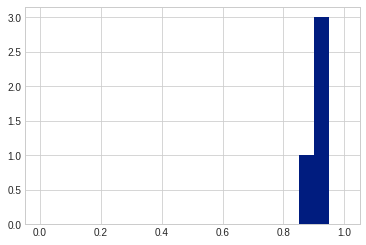

In [26]:
siamese_pipe = Pipeline([
    ('RobustScalerForPandas', RobustScalerForPandas()),
    ('SimplestSiameseModel', SimplestSiameseModel(inp_shape=(len(base_feature_names),))),
])

siamese_pipe.only_feature_diffs = False
siamese_pipe.feature_names = base_feature_names


scores, best_siamese_pipe, y_true, y_pred = custom_cross_val_auc_score(
    siamese_pipe,
    DF_registration_train,
)

plt.hist(scores, range=(0, 1), bins=20);

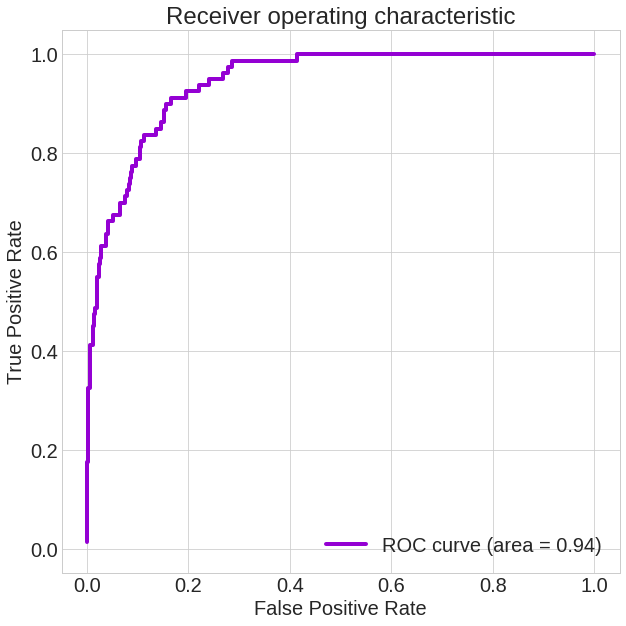

In [27]:
plot_auc(y_true, y_pred)

## Siamese neural network with recurrent cell(s) <a name="siamese_rnn"></a>

In [28]:
DF_train_all_pairs = extract_pairs(DF_registration_train, ['sequence'], only_feature_diffs=False)
print(
    'Fraction of positive observations: {:.4f}'
    .format(DF_train_all_pairs['label'].mean())
)
DF_train_all_pairs.head()

Fraction of positive observations: 0.0247


,sequence_A,sequence_B,label
0,"[0, 168353, 369433, 514708, 1020553, 1218599, ...","[0, 100425, 153185, 274344, 423285, 569246, 49...",0
1,"[0, 168353, 369433, 514708, 1020553, 1218599, ...","[0, 96958, 111930, 240003, 303073, 462375, 387...",0
2,"[0, 168353, 369433, 514708, 1020553, 1218599, ...","[0, 103880, 111979, 250424, 330662, 483232, 40...",0
3,"[0, 168353, 369433, 514708, 1020553, 1218599, ...","[0, 117738, 122377, 236635, 340913, 520701, 42...",0
4,"[0, 168353, 369433, 514708, 1020553, 1218599, ...","[0, 124650, 129292, 264290, 389175, 565608, 47...",0


<img src="images/siamese_gru.png" alt="Drawing" style="width: 800px;"/>

The GRU (Gated Recurrent Unit) is an architecture whose state can hold more information than the state of a standard RNN unit (roughly speaking, it has a better "memory"), and can thus give better predictions.

<img src="images/gru_colah.png" alt="Drawing" style="width: 800px;"/>

Source: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [29]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import GRU, LSTM


class RNNSiameseModel:
    """(Same doc as for MLPKerasWrapper).
    
    This class implements a siamese architecture, in which the base model
    is a recurrent neural network (GRU, to be exact).
    """
    
    def __init__(self, inp_shape, max_length,
                 num_epochs=10, num_neurons=40):
        self.inp_shape = inp_shape
        self.num_neurons = num_neurons
        self.num_epochs = num_epochs
        self.max_length = max_length

    def fit(self, DF_data, y):
        padded_seq_A = self._prep_sequences(DF_data['sequence_A'])
        padded_seq_B = self._prep_sequences(DF_data['sequence_B'])
        
        self._init_model()
        
        self.siamese_net.fit(
            x=[padded_seq_A, padded_seq_B],
            y=y,
            batch_size=32,
            epochs=self.num_epochs,
            verbose=2,
        )

    def predict_proba(self, DF_data):
        padded_seq_A = self._prep_sequences(DF_data['sequence_A'])
        padded_seq_B = self._prep_sequences(DF_data['sequence_B'])
        return self.siamese_net.predict([padded_seq_A, padded_seq_B])
    
    def _init_model(self):
        input_A = Input(shape=(None, self.max_length))
        input_B = Input(shape=(None, self.max_length))

        base_network = self._create_base_network()

        leg_A = base_network(input_A)
        leg_B = base_network(input_B)

        # Merge two representations using the absolute difference between them
        def abs_diff(x): return K.abs(x[0] - x[1])
        diff = Lambda(function=abs_diff,
                      output_shape=lambda x: x[0])([leg_A, leg_B])
        x = Dense(self.num_neurons)(diff)
        x = ELU()(x)
        prediction = Dense(1, activation='sigmoid')(x)

        self.siamese_net = Model([input_A, input_B], prediction)
        self.siamese_net.compile(
            optimizer='adam',
            loss='binary_crossentropy',
        )

    def _create_base_network(self):
        inp = Input(shape=(None, self.max_length))
        x, state = GRU(64, return_state=True)(inp)  # TODO(1): can we do better?
        x = ELU()(state)
        return Model(inputs=inp, outputs=x)
    
    def _extract_colnames(self, columns):
        columns_A = columns[columns.str.contains('_A')]
        columns_B = columns[columns.str.contains('_B')]
        return columns_A, columns_B
    
    def _prep_sequences(self, seq):
        # TODO(2): this can be moved to a transformer that also normalizes the diffs
        seq_diff = seq.apply(np.diff)
        padded_seq = pad_sequences(seq_diff, maxlen=self.max_length)
        return np.expand_dims(padded_seq, 1)

In [ ]:
feature_names = base_feature_names + ['sequence']
max_length = DF_whole['sequence'].apply(len).max()

# TODO(2): add a transformer (like RobustScalerForPandas)
# that will preprocess the sequences, so that there's
# no need of doing that in RNNSiameseModel._prep_sequences

rnn_siamese_pipe = Pipeline([
    ('RNNSiameseModel', 
     RNNSiameseModel(inp_shape=(len(base_feature_names), ), max_length=max_length)),
])

rnn_siamese_pipe.only_feature_diffs = False
rnn_siamese_pipe.feature_names = feature_names


# TODO(3): results for this model are considerably worse than
# for others. Consider:
# 1. applying the following sign_log function to the diffs:
# def sign_log(x):
#     return np.sign(x)*np.log1p(np.abs(x))
# 2. adding dwell and flight times sequences (but that wouldn't exactly be feature learning...)
scores, best_rnn_siamese_pipe, y_true, y_pred = custom_cross_val_auc_score(
    rnn_siamese_pipe,
    DF_registration_train,
)

plt.hist(scores, range=(0, 1), bins=20);

In [ ]:
plot_auc(y_true, y_pred)

# Tests: user verification <a name="testing"></a>

<img src="images/testing_all_vs_one.png" alt="Drawing" style="width: 800px;"/>

In [ ]:
from pair_data import get_pair_data


def regist_vs_one_predictions(DF_regist, DF_one_row, pipe):
    """Function for making predictions for all pairs of rows
    between the registration data (DF_regist), and the singular
    row that needs to be verified (DF_one_row).
    
    Predictions are carried out by the pipe object, and the final
    prediction is taken to be the mean of all predictions.
    
    TODO(3): can we do better? Can we utilize the information
    about how similar/dissimilar the DF_one_row is to the rows
    in DF_regist? Maybe a different statistic (max, min) works
    better? 
    """
    DF_pair_data = get_pair_data(
        pipe.only_feature_diffs,
        DF_regist,
        DF_one_row,
    )
    y_pred = pipe.predict_proba(DF_pair_data)
    if y_pred.shape[1] == 2:
        y_pred = y_pred[:, 1]
        
    return np.mean(y_pred)  # TODO(3): can we do better?


def test_user_verification(pipe, test_user_names, DF_whole):
    """Function for testing the pairwise model, by checking whether
    new keystroke dynamics match those provided during registration.
    
    Args:
        pipe: Pipeline (or a bare estimator) for performing the matching;
            it MUST have attributes only_feature_diffs, and feature_names,
            which are required to produce a frame with the right columns
            for pipe.
            
        test_user_names: a list of user names, which will be used for
            testing.
            
        DF_whole: a pd.DataFrame with both registration, and test rows.
            
    Returns:
        A list of AUC scores calculated from the verification.
    """
    feature_names = pipe.feature_names
    only_feature_diffs = pipe.only_feature_diffs
    
    auc_scores = []
    for user_name in test_user_names:
        DF_one_user = DF_whole.query('user_name == @user_name')
        DF_regist = DF_one_user.query('registration == 1')[feature_names]
        DF_not_regist = DF_one_user.query('registration != 1')
        
        same_person = 1 - DF_not_regist['imposter']
        if same_person.sum() == 0:
            print('No positive examples for user "{}"'.format(user_name))
            continue
        if same_person.sum() == len(same_person):
            print('No negative examples for user "{}"'.format(user_name))
            continue

        num_rows = DF_not_regist.shape[0]
        preds = []
        for row_number in range(num_rows):
            DF_one_row = DF_not_regist[feature_names].iloc[[row_number]]
            pred = regist_vs_one_predictions(DF_regist, DF_one_row, pipe)
            preds.append(pred)

        auc_score = roc_auc_score(same_person, preds)
        auc_scores.append(auc_score)
        
        msg = 'AUC score: {:.2f} for user "{}"'.format(auc_score, user_name)
        if auc_score <= 0.5:
            msg += ' (definitely wrong)'
        print(msg)
        
    print('*** Mean AUC score: {:.4f} ***'.format(np.mean(auc_scores)))
    return auc_scores

In [ ]:
print('XGB pipeline')
scores = test_user_verification(best_xgb_pipe, test_user_names, DF_whole)
plt.hist(scores, range=(0, 1), bins=20);

In [ ]:
print('MLP pipeline')
scores = test_user_verification(best_mlp_pipe, test_user_names, DF_whole)
plt.hist(scores, range=(0, 1), bins=20);

In [ ]:
print('Simple siamese pipeline')
scores = test_user_verification(best_siamese_pipe, test_user_names, DF_whole)
plt.hist(scores, range=(0, 1), bins=20);

In [ ]:
print('RNN siamese pipeline')
scores = test_user_verification(best_rnn_siamese_pipe, test_user_names, DF_whole);
plt.hist(scores, range=(0, 1), bins=20);